<h1> Tasa de Desempleo de EEUU </h1>
<hr>

Para el desarrollo de este proyecto, se realizó la descarga de la base de datos. Se tomó desde Enero de 1948 hasta Diciembre de 2019. Aunque el assement decía que era hasta el 2017, se tomaron 2 años de más para ver que tan buenas serían las predicciones acorde a los modelos que se implementarán. A continuación realizamos la carga de los modulos implementados para este análisis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import datetime as dt
import re

Cargadas las librerías a utilizar, se procede a cargar la información que se requiere:

In [2]:
df = pd.read_csv("UNRATE.csv")
df["DATE"] = pd.DatetimeIndex(df["DATE"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d")))
df["MES"]  = df.reset_index()["DATE"].apply(lambda x: x.month)
df["ANIO"]  = df.reset_index()["DATE"].apply(lambda x: x.year)
df["UNRATE_DIFF"] = df["UNRATE"].diff()
df.set_index("DATE", inplace=True)
df.head()

,UNRATE,MES,ANIO,UNRATE_DIFF
DATE,,,,
1948-01-01,3.4,1,1948,NaN
1948-02-01,3.8,2,1948,0.4
1948-03-01,4.0,3,1948,0.2
1948-04-01,3.9,4,1948,-0.1
1948-05-01,3.5,5,1948,-0.4


A continuación se realiza un gráfico para visualizar los gráficos que se manejarán. En la parte superior del gráfico se tendrá la serie de tiempo del desempleo tal cual se está observando, en la parte inferior se tendrán dos gráficos. Uno, que presenta los valores de la tasa de desempleo por mes y año, y el otro, presenta cómo se ha comportado esta variable teniendo en cuenta cada unos de sus meses y sus medias.

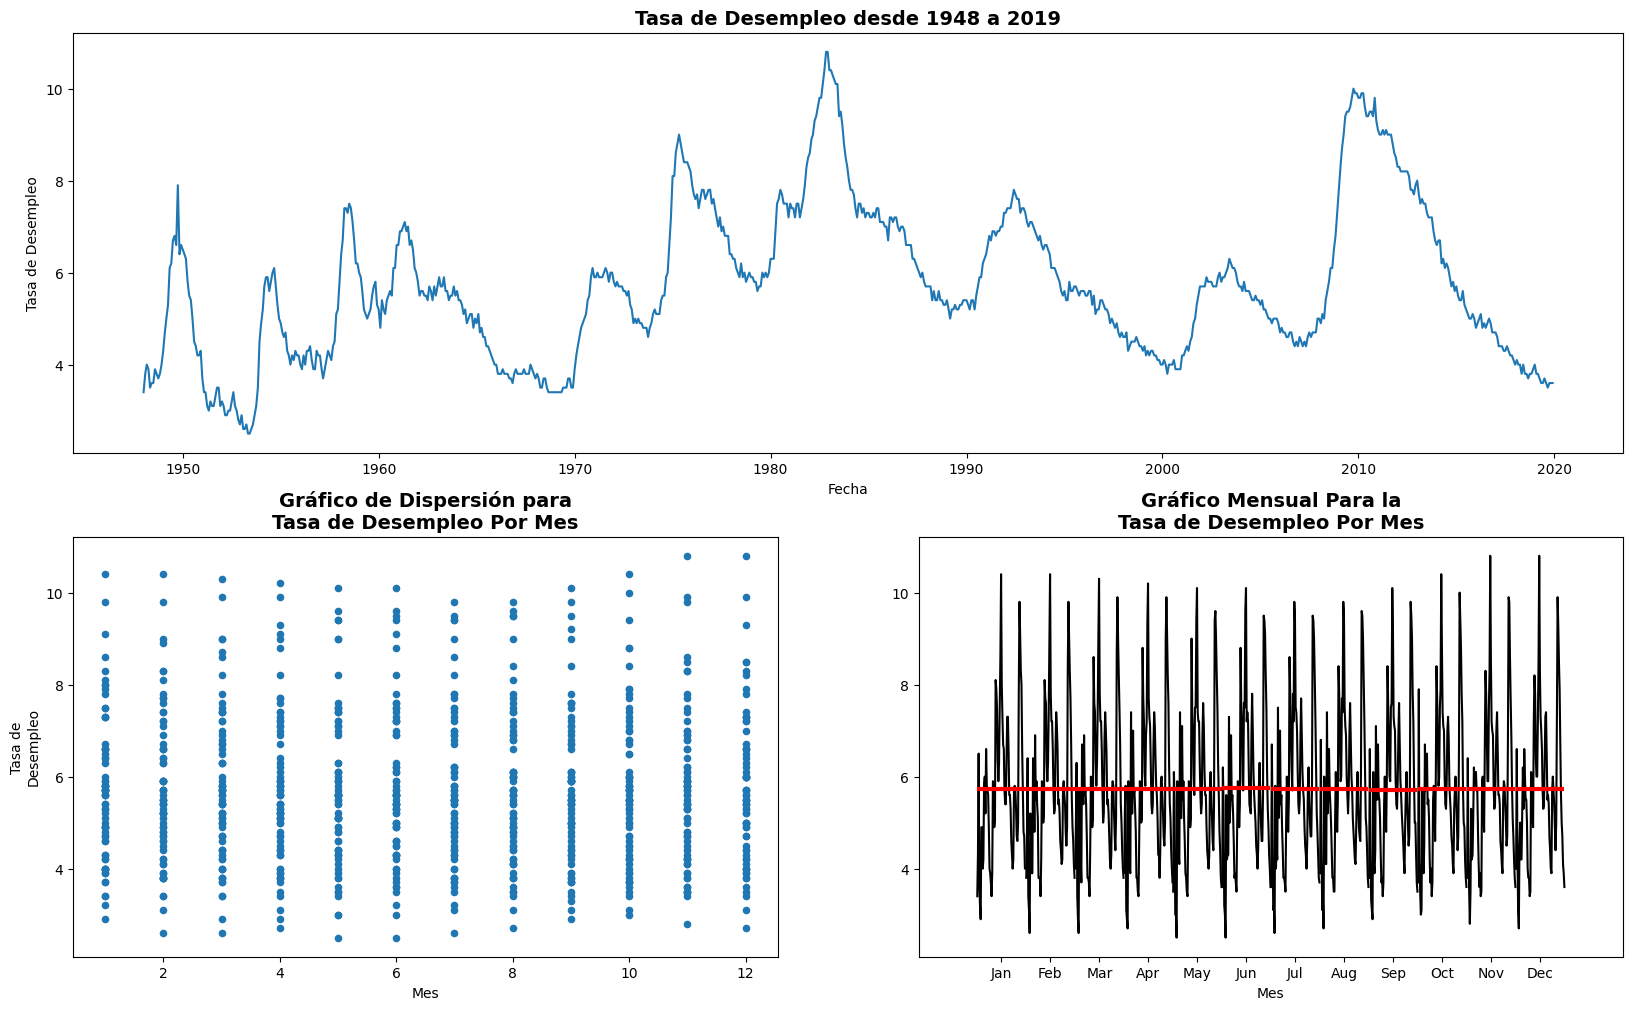

In [3]:
mosaic = [["A", "A"],
          ["B", "C"]]

plt.rc("axes", labelsize = 10, titlesize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

fig, ax = plt.subplot_mosaic(mosaic, figsize = (20, 12))

ax["A"].plot(df.reset_index()["DATE"],df["UNRATE"])
ax["A"].set_title("Tasa de Desempleo desde 1948 a 2019", fontweight = "bold")
ax["A"].set_xlabel("Fecha")
ax["A"].set_ylabel("Tasa de Desempleo")

(
    df.
    groupby(["MES", "ANIO"]).
    agg(
        UNRATE = ("UNRATE", "mean")
    ).
    reset_index().
    plot(x = "MES", y = "UNRATE", kind="scatter", ax = ax["B"])
)

ax["B"].set_title("Gráfico de Dispersión para\nTasa de Desempleo Por Mes", fontweight = "bold")
ax["B"].set_xlabel("Mes")
ax["B"].set_ylabel("Tasa de\nDesempleo")

ax["C"].set_title("Gráfico Mensual Para la\nTasa de Desempleo Por Mes", fontweight = "bold")
ax["C"].set_xlabel("Mes")
ax["C"].set_ylabel("Tasa de\nDesempleo")

sm.graphics.tsa.month_plot(df[["UNRATE"]], ax = ax["C"])
plt.show()

Para responder la primera pregunta, se tiene lo siguiente. Cuando se trabaja con series de tiempo se suele aplicar una descomposición en dos partes:

<ol>
<li><strong>Tendencia</strong>: Esta hace referencia al comportamiento general de la serie de tiempo, es decir, al analizar de manera global los datos, si presentan algún comportamiento específico. </li>
<li><strong>Estacional</strong>: Este hace referencia al comportamiento que se puede presentar de manera cíclica a lo largo del perido. En este caso no nos centramos en ver cómo se comporta de manera general los datos sino nos enfocamos en periodos de tiempo en los cuales se puedan presentar patrones.
</ol>

El siguiente gráfico presenta el comportamiento de la serie de tiempo, incluyendo la tendencia y aparte cómo es la estacionalidad junto con sus residuos. Cabe mencionar que el modelo implementado es aditivo:

$$y_t = \tau_t + S_t + R_t $$

El término $y_t$ hace referencia al valor de la variable observada, $\tau$ es el valor de la tendencia, $S$ es la estacionalidad y $R$ es el  valor del residuo en el tiempo $t$.


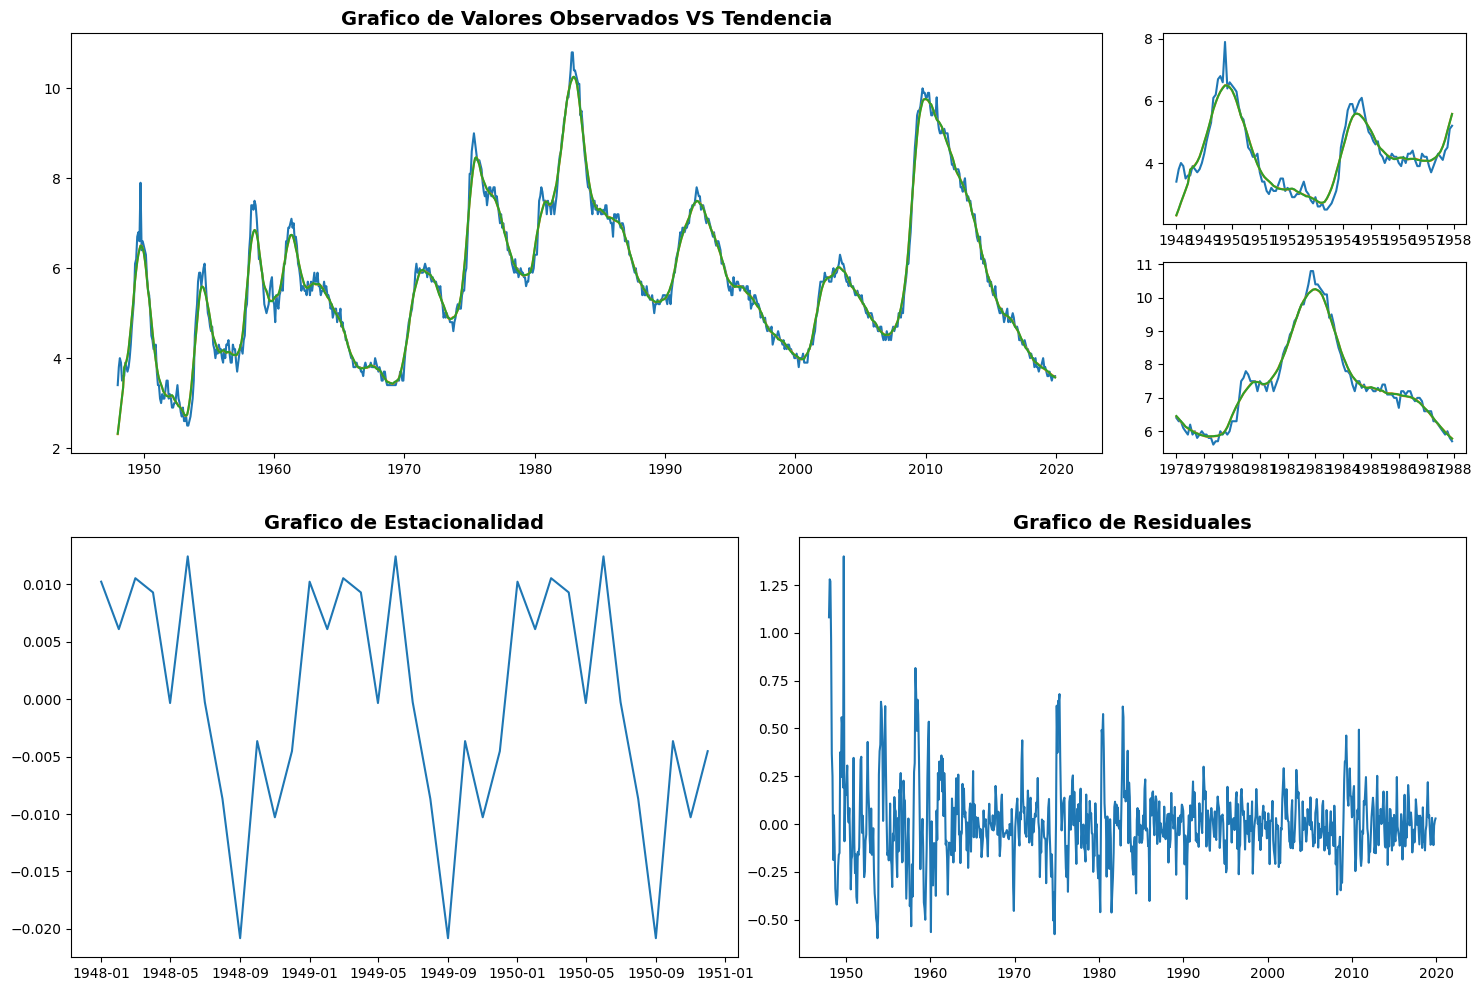

In [4]:
md = seasonal_decompose(df[["UNRATE"]], model="additive", period=12, extrapolate_trend='freq')

plt.rc("axes", labelsize = 7, titlesize=14) 

mosaic = [["A", "A", "A", [["A1"], ["A2"]]],
          ["C", "C", "D", "D"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (18,12))

ax["A"].plot(md.observed)
ax["A"].plot(md.trend)
ax["A"].plot(md.trend+md.seasonal)

ax["A1"].plot(md.observed[0:120])
ax["A1"].plot(md.trend[0:120])
ax["A1"].plot(md.trend[0:120]+md.seasonal[0:120])

ax["A2"].plot(md.observed[360:480])
ax["A2"].plot(md.trend[360:480])
ax["A2"].plot(md.trend[360:480]+md.seasonal[360:480])

ax["C"].plot(md.seasonal[0:36])
ax["D"].plot(md.resid)

ax["A"].set_title("Grafico de Valores Observados VS Tendencia", fontweight = "bold")
ax["C"].set_title("Grafico de Estacionalidad", fontweight = "bold")
ax["D"].set_title("Grafico de Residuales", fontweight = "bold")

plt.show()

Para visualizar un poco más a profundidad a qué se hace refente la tendecia y la estacionalidad, el siguiente gráfico presenta los resultados obtenidos pero teniendo un perido de 10 años:

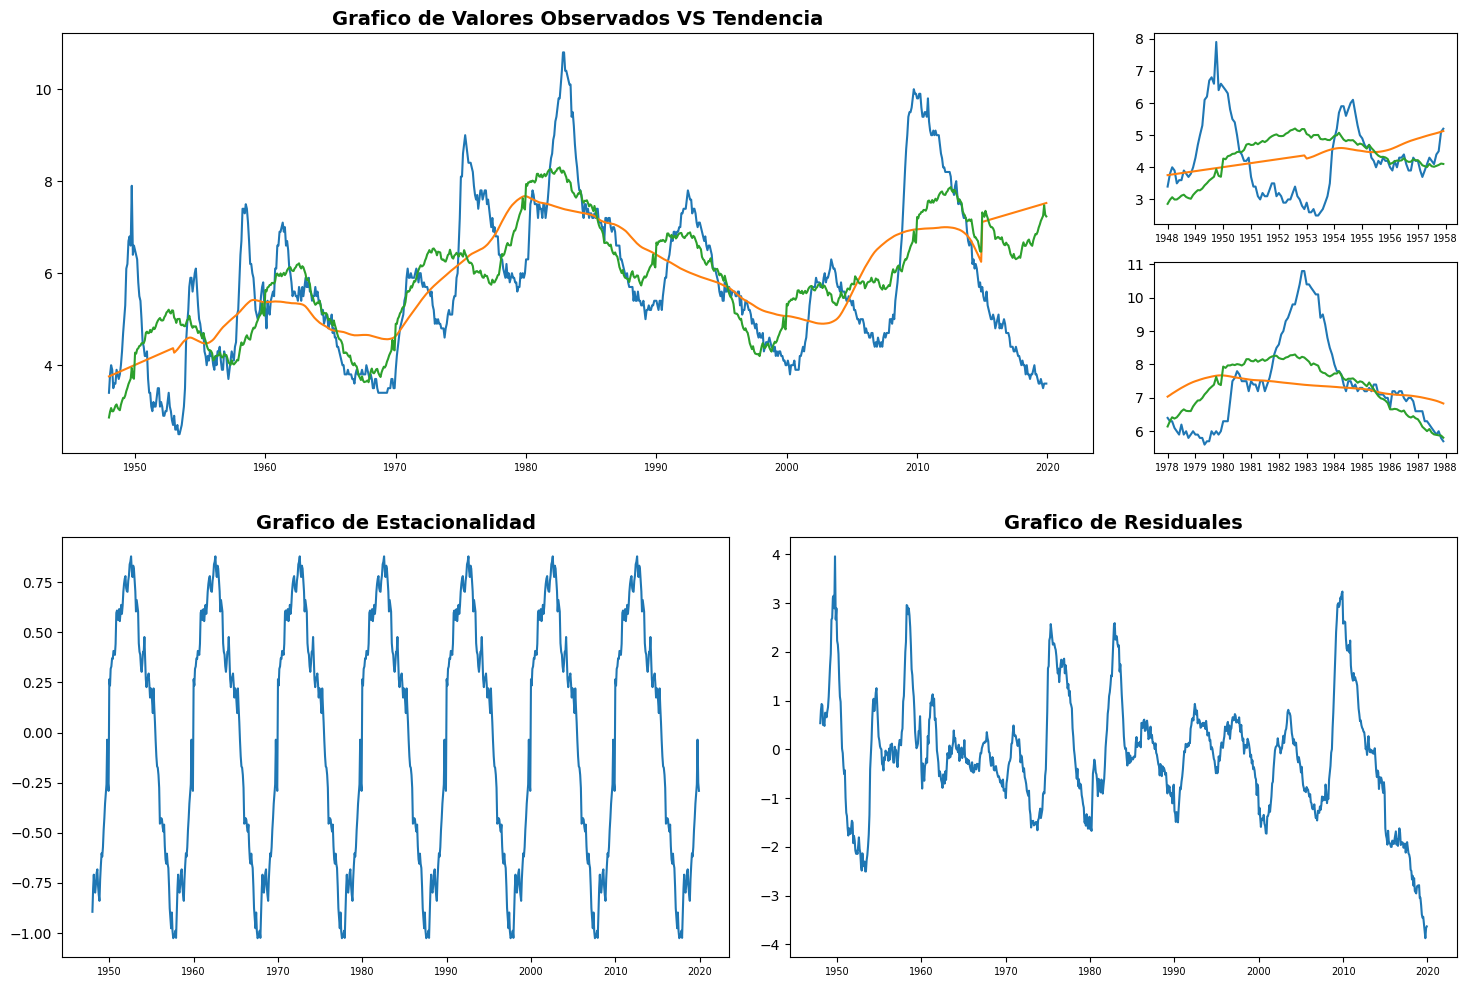

In [5]:
md = seasonal_decompose(df[["UNRATE"]], model="additive", period=120, extrapolate_trend='freq')

plt.rc("axes", labelsize = 7, titlesize=14) 
plt.rc("xtick", labelsize = 7)

mosaic = [["A", "A", "A", [["A1"], ["A2"]]],
          ["C", "C", "D", "D"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (18,12))

ax["A"].plot(md.observed)
ax["A"].plot(md.trend)
ax["A"].plot(md.trend+md.seasonal)

ax["A1"].plot(md.observed[0:120])
ax["A1"].plot(md.trend[0:120])
ax["A1"].plot(md.trend[0:120]+md.seasonal[0:120])

ax["A2"].plot(md.observed[360:480])
ax["A2"].plot(md.trend[360:480])
ax["A2"].plot(md.trend[360:480]+md.seasonal[360:480])

ax["C"].plot(md.seasonal)
ax["D"].plot(md.resid)

ax["A"].set_title("Grafico de Valores Observados VS Tendencia", fontweight = "bold")
ax["C"].set_title("Grafico de Estacionalidad", fontweight = "bold")
ax["D"].set_title("Grafico de Residuales", fontweight = "bold")

plt.show()